# Advanced Lane Finding

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply the distortion correction to the raw image.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find lane boundary.
6. Determine curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

NOTE. The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. The video called project_video.mp4 is the video your pipeline should work well on. challenge_video.mp4 is an extra (and optional) challenge for you if you want to test your pipeline.

If you're feeling ambitious (totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import glob, os
from scipy import misc
from scipy.misc import imresize
import pickle
import matplotlib.image as mpimg

In [2]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #print(gray)
    # Sobel x or y
    if orient == "x":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    if orient == "y":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
        
    abssxy = np.absolute(sobelxy) # Absolute xy derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssxy)/255 # Will use this to scale back to 8-bit scale
    abssxy = (abssxy/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold xy gradient
    retval, sxybinary = cv2.threshold(abssxy, thresh[0], thresh[1], cv2.THRESH_BINARY)


    return sxybinary

def mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    #print(gradmag)

    retval, mag_binary = cv2.threshold(gradmag, mag_thresh[0], mag_thresh[1], cv2.THRESH_BINARY)
    
    return mag_binary

def dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.4)):
    
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # To avoid error messages due to diving by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        
    return dir_binary

def rgb2hls(img, thresh=(0, 255)):    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    #print(s)
    
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    
    #print(s_binary)
    
    
    return s_binary

In [3]:
def show_images(images,row,col, title):
        
    #Split the figure in x rows and y columns to put images
    figure, axes = plt.subplots(row,col, figsize=(24, 9))

    # hspace vertical space reserve for white space between subplots
    # wspace horizontal space reserve for white space between subplots
    figure.subplots_adjust(hspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        image_shape = np.shape(images[i])
        ax.imshow(images[i].reshape(image_shape), cmap='gray')

        ax.set_xticks([])
        ax.set_yticks([])
        index = i +1
        msg = str("Test %g"%index + "_%s"%title)
        ax.set_title(msg)
        
    plt.subplots_adjust(left=0., right=0.4, top=0.9, bottom=0.)

    plt.show()

In [4]:
gradx_l = []
grady_l = []
mag_binary_l = []
dir_binary_l = []
combined_l = []
hls_list = []
ksize = 15


# Make a list of test images

images = glob.glob('test_images/undis*.jpg')
for idx, image in enumerate(images):
    name = image.split('/')
    img =  mpimg.imread(image)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh= (0.7, 1.4))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    convert2hls = rgb2hls(img,thresh=(150, 250))
    
    gradx_l.append(gradx)
    grady_l.append(grady)
    mag_binary_l.append(mag_binary)
    dir_binary_l.append(dir_binary)
    combined_l.append(combined)
    hls_list.append(convert2hls)

# Plot the result   
n_row = 3
n_col =2


In [5]:
#show_images(gradx_l,n_row,n_col,"Gradx")

In [6]:
#show_images(grady_l,n_row,n_col,"Grady")

In [7]:
#show_images(mag_binary_l,n_row,n_col,"Magnitude")

In [8]:
#show_images(dir_binary_l,n_row,n_col,"Direction")

In [9]:
#show_images(combined_l,n_row,n_col,"Combined")

In [10]:
#show_images(hls_list,n_row,n_col,"HLS")

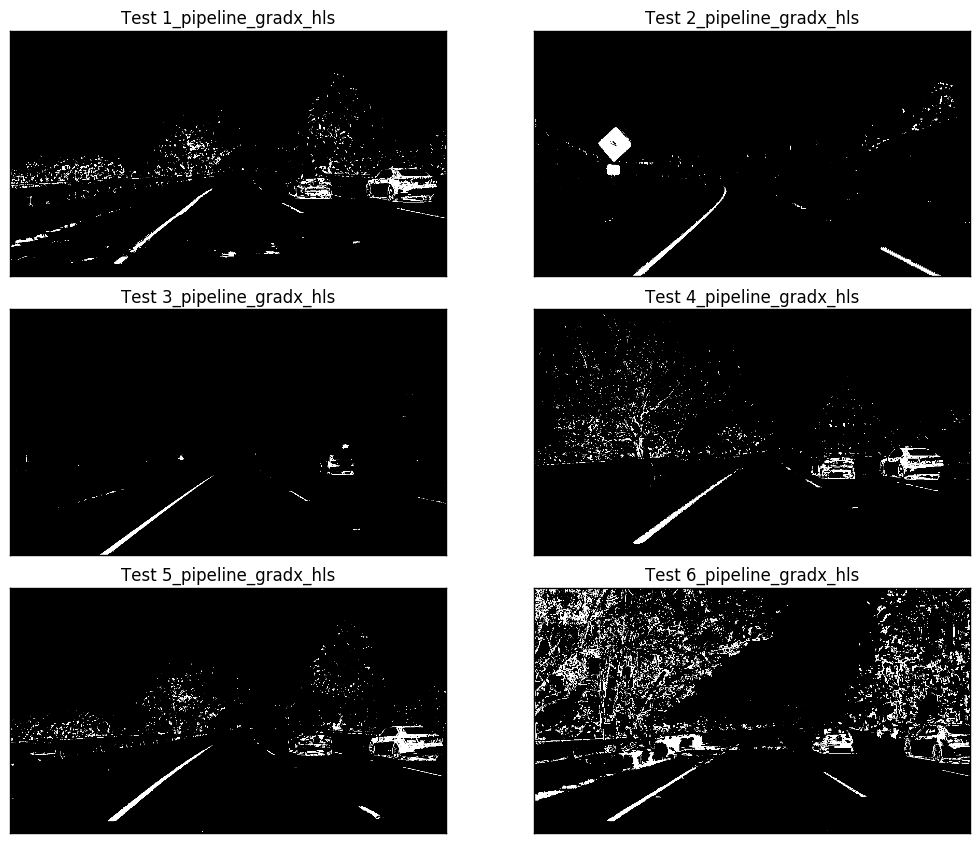

In [11]:
%matplotlib inline
def pipeline_gradx_hls(img):
    img = np.copy(img)

    #HLS
    s_binary= rgb2hls(img, thresh=(150, 250))
    
   
    # Gradient x
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(100, 250))

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary),sxbinary, s_binary))
    combined_binary = np.clip(cv2.bitwise_or(s_binary, sxbinary), 0, 1).astype('uint8')
    
    return combined_binary
    
images_filtered =[]
images = glob.glob('test_images/*.jpg')
for idx, image in enumerate(images):
    name = image.split('/')
    img =  mpimg.imread(image)
    filtered= pipeline_gradx_hls(img)
    #print (filtered)
    images_filtered.append(filtered)

show_images(images_filtered,n_row,n_col,"pipeline_gradx_hls")
    

In [12]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
#print(mtx.shape)
#print(dist.shape)


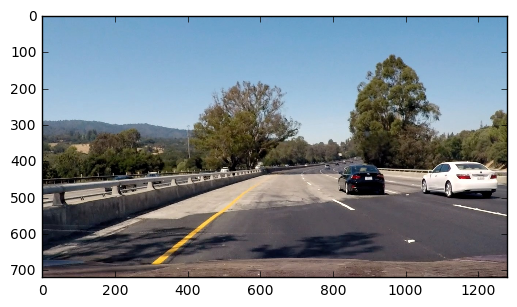

In [13]:
# Read in an image
%matplotlib inline
img = mpimg.imread('test_images/test4.jpg')

plt.imshow(img)


In [14]:
def corners_unwarp(img, nx, ny, mtx, dist):  
    img_size = (img.shape[1],img.shape[0])
    offset = 100
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    #gray = cv2.cvtColor(undst,cv2.COLOR_BGR2GRAY)
    
    corners_ul = (531,501)
    corners_ur = (795,501)
    corners_bl = (492,534)
    corners_br = (853,534)
    
    
    
    src = np.float32([corners_ul, corners_ur, corners_br, corners_bl])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    
    M = cv2.getPerspectiveTransform(src, dst)
        
    warped = cv2.warpPerspective(undst, M, img_size)      

 
    return warped, M



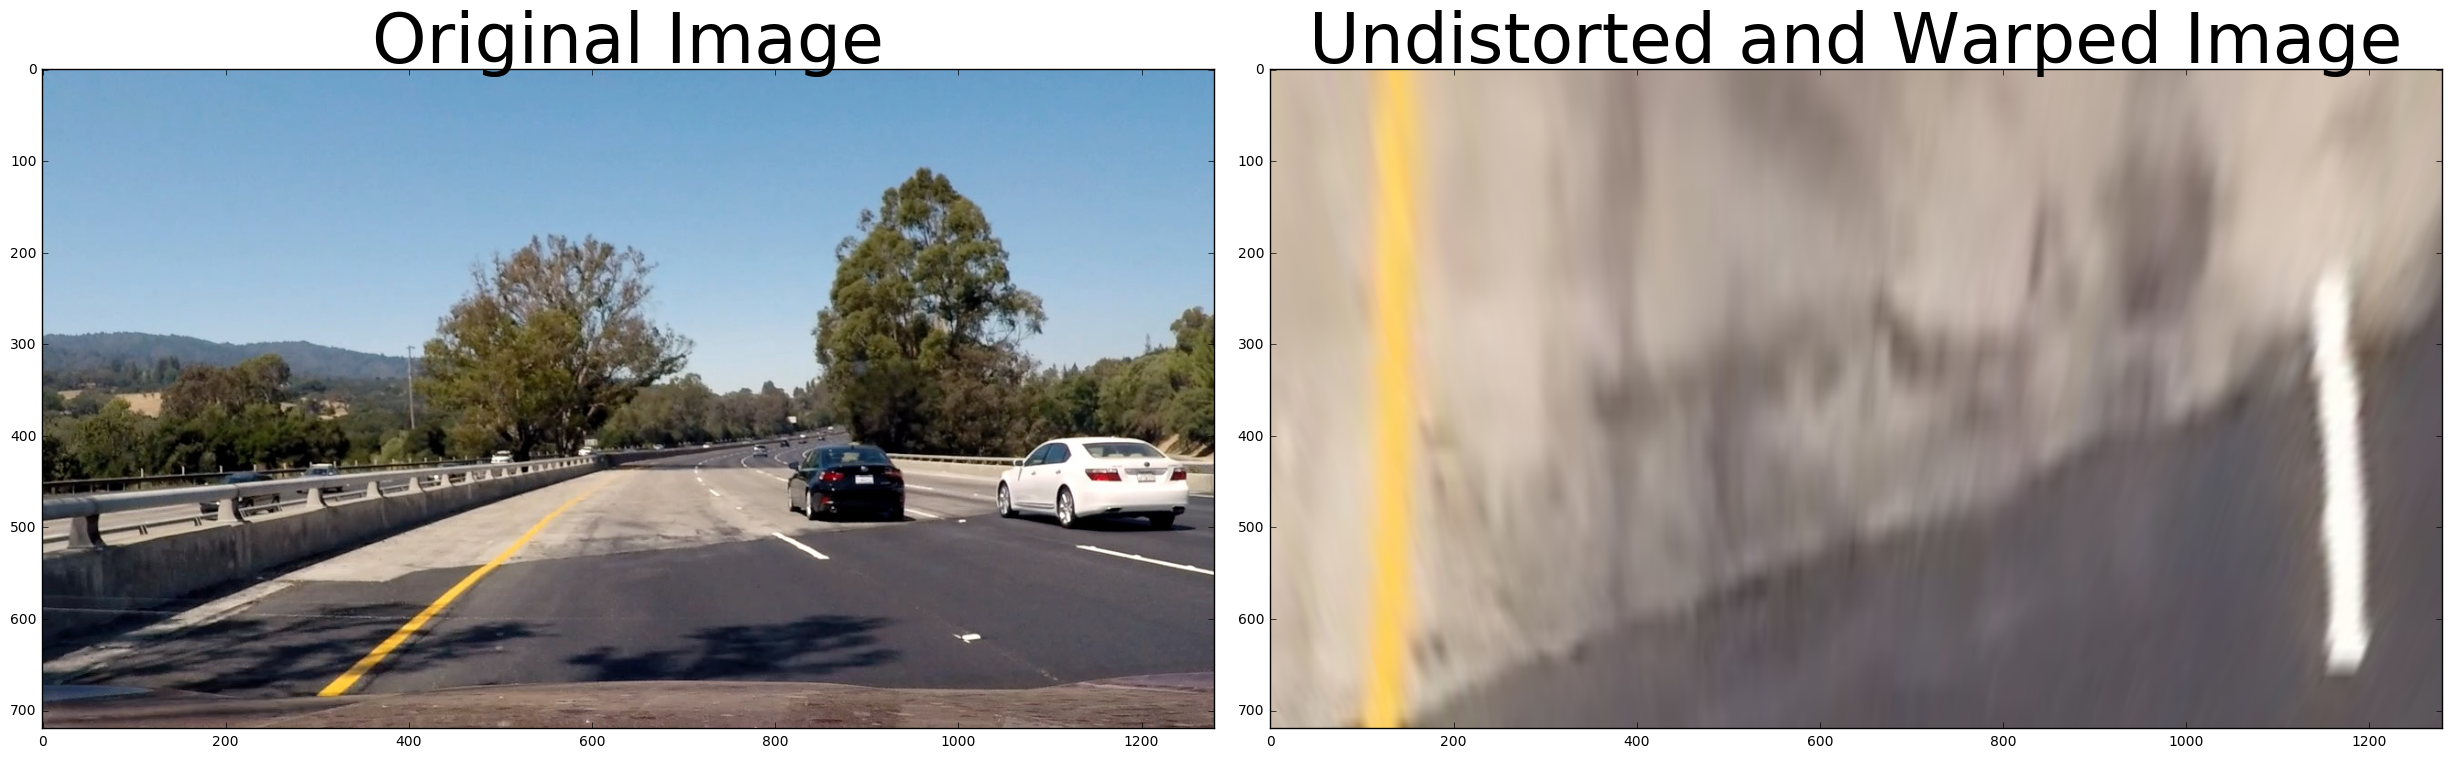

In [15]:
%matplotlib inline
nx = 9
ny = 6

img = mpimg.imread('test_images/test4.jpg')

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

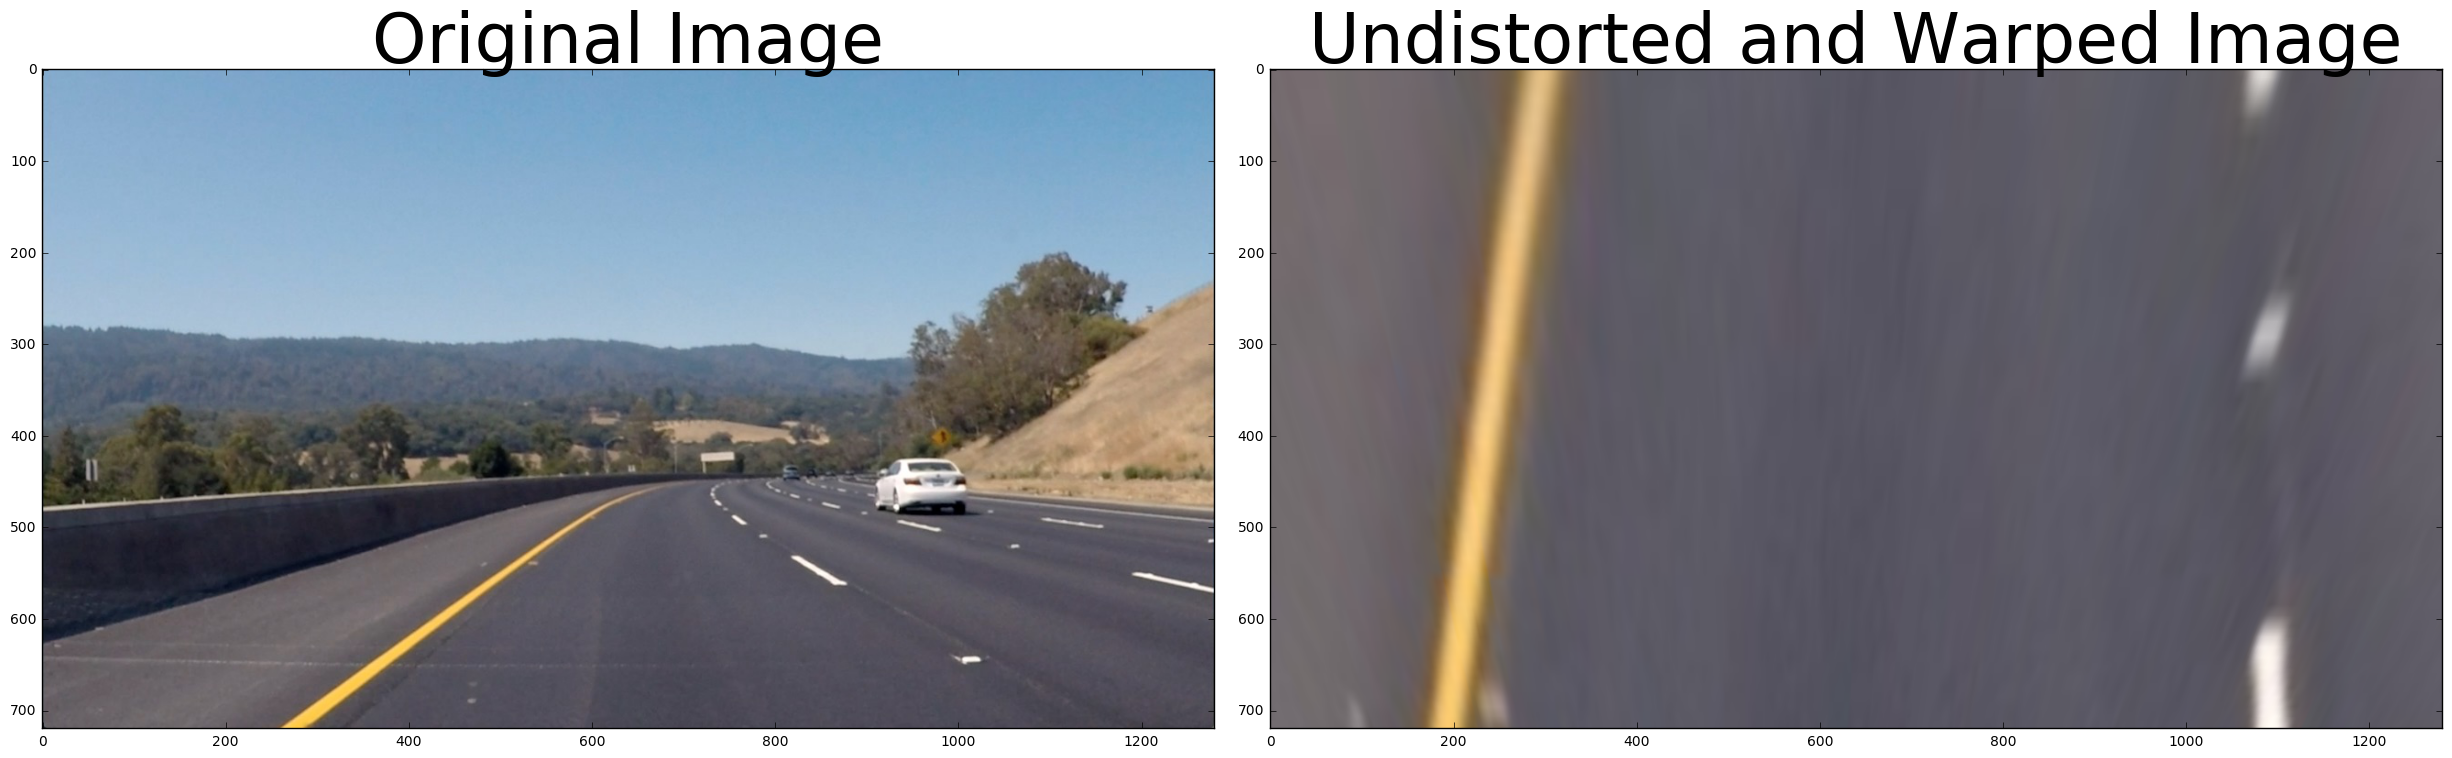

In [96]:
%matplotlib inline
nx = 9
ny = 6

img = mpimg.imread('test_images/test3.jpg')

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

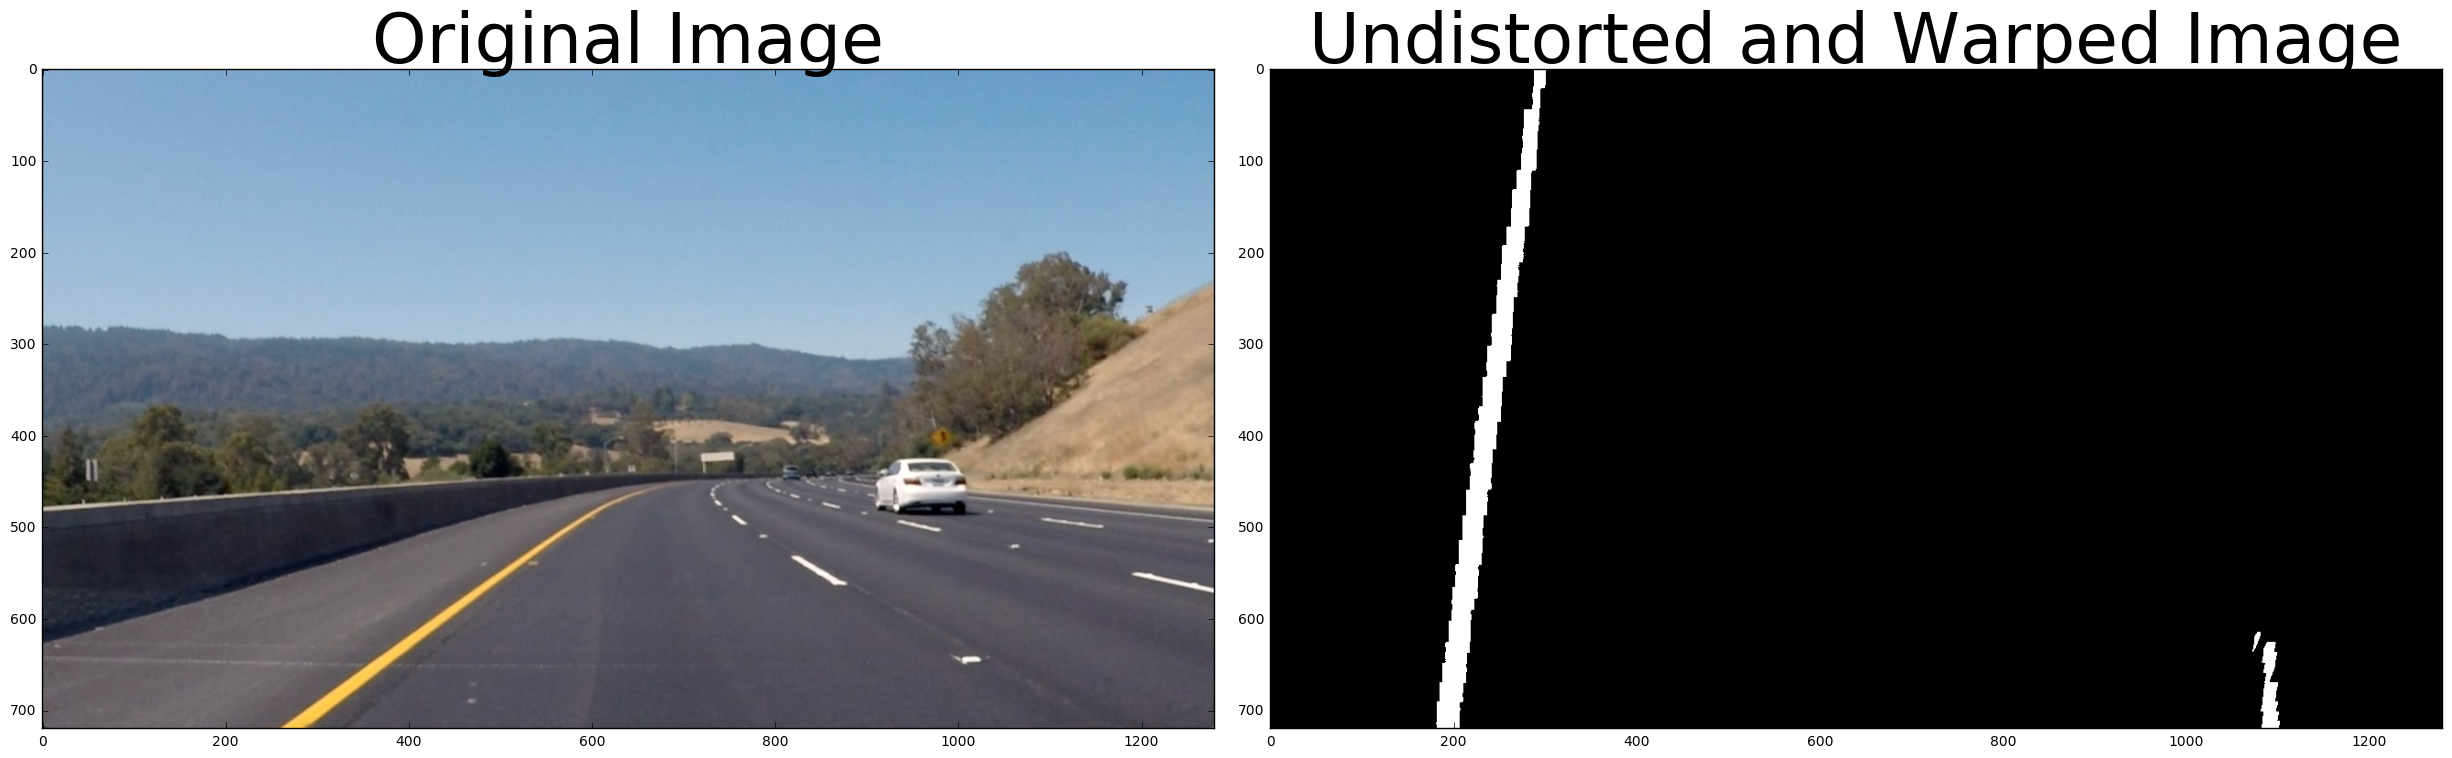

In [245]:
%matplotlib inline
img = mpimg.imread('test_images/test3.jpg')
result = pipeline_gradx_hls(img)
top_down, perspective_M = corners_unwarp(result, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


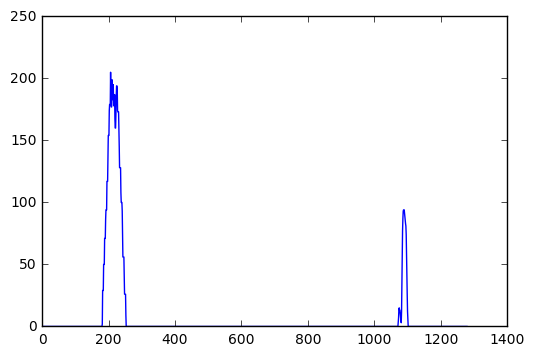

In [254]:
from matplotlib import interactive
interactive(True)
%matplotlib inline

#%matplotlib notebook
out = np.zeros(img.shape[1])
histogram = np.sum(top_down[img.shape[0]/2:,:], axis=0, out = out)
plt.plot(histogram)

In [253]:
def find_peaks(array, start=0):
    first_peak = np.argmax(array)
    value_peak = array[first_peak]
    dummy_array = array[first_peak:]

    counter = 0
    for index in dummy_array:
        if index != 0:
            counter = counter +1
        
        else:
            second_peak = first_peak+counter
            break
    
    center = first_peak + (second_peak+start - first_peak+start)/2
    
    return first_peak+start, second_peak+start, center

In [238]:
def find_one_peak(image):
    out = np.zeros(img.shape[1])
    histogram = np.sum(top_down[img.shape[0]/2:,:], axis=0, out = out)
    
    first_half = len(histogram)/2
    left = histogram[:first_half]
    left_first_peak = np.argmax(left)
    left_value_peak = left[left_first_peak]
    
    right = histogram[first_half:]
    right_first_peak = np.argmax(right)
    right_value_peak = left[right_first_peak]
     
    
    dummy_left_array = left[left_first_peak:]

    counter = 0
    for index in dummy_left_array:
        if index != 0:
            counter = counter +1
        
        else:
            left_second_peak = left_first_peak+counter
            break
    
    center = left_first_peak + (left_second_peak - left_first_peak)/2
    
    return center

In [239]:
def find_two_peaks(image, side='left'):
    out = np.zeros(img.shape[1])
    histogram = np.sum(top_down[img.shape[0]/2:,:], axis=0, out = out)
    
    first_half = len(histogram)/2
    left = histogram[:first_half]
    left_first_peak = np.argmax(left)
    left_value_peak = left[left_first_peak]
    
    right = histogram[first_half:]
    right_first_peak = np.argmax(right)
    right_value_peak = left[right_first_peak]
     
    
    dummy_left_array = left[left_first_peak:]

    counter = 0
    for index in dummy_left_array:
        if index != 0:
            counter = counter +1
        
        else:
            left_second_peak = left_first_peak+counter
            break
    
    left_center = left_first_peak + (left_second_peak - left_first_peak)/2
    
    
    
    dummy_right_array = right[right_first_peak:]

    counter = 0
    for index in dummy_right_array:
        if index != 0:
            counter = counter +1
        
        else:
            right_second_peak = right_first_peak+counter
            break
    
    
    right_center = (right_first_peak + (right_second_peak- right_first_peak)/2) + first_half 
    
    if side == 'left':
        center = left_center
        
    else:
        center = right_center
    
    return center

In [240]:
%matplotlib inline

def find_two_peaks_image(image, side='left'):
    #plt.imshow(image,cmap='gray')

    out = np.zeros(image.shape[1])
    histogram = np.sum(image, axis=0, out = out)
    #plt.plot(histogram)
    
    first_half = len(histogram)/2
    left = histogram[:first_half]
    left_first_peak = np.argmax(left)
    left_value_peak = left[left_first_peak]
    
    right = histogram[first_half:]
    right_first_peak = np.argmax(right)
    right_value_peak = left[right_first_peak]
     
    
    dummy_left_array = left[left_first_peak:]

    counter = 0
    for index in dummy_left_array:
        if index != 0:
            counter = counter +1
            left_second_peak = left_first_peak+counter
            
        
        else:
            left_second_peak = left_first_peak+counter
            break
    
    left_center = left_first_peak + (left_second_peak - left_first_peak)/2
    
    
    
    dummy_right_array = right[right_first_peak:]

    counter = 0
    for index in dummy_right_array:
        if index != 0:
            counter = counter +1
        
        else:
            right_second_peak = right_first_peak+counter
            break
    
    
    right_center = (right_first_peak + (right_second_peak- right_first_peak)/2) + first_half 
    
    if side == 'left':
        center = left_center
        
    else:
        center = right_center
    
    return center

In [224]:
center1= find_two_peaks(top_down)
center2 = find_two_peaks(top_down, 'right')

print (center1,center2)

229.5 1095.0


/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [186]:
first_half = len(histogram)/2
left = histogram[:first_half]
x1, x2, center1 = find_peaks(left)
print(x1, x2, center1)

right = histogram[first_half:]
x3, x4, center2 = find_peaks(right, first_half)
print(x3, x4,center2)


206 253 229.5
1088.0 1102.0 1095.0


/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [261]:
def sliding_window(image, left_start, right_start, delta):
    WIDTH = image.shape[1]
    WINDOW_WIDTH = 100
    print(WIDTH)
    HEIGTH = image.shape[0]
    print('start', left_start)
    
    sections = int(HEIGTH / delta)
    x_centers = []
    y_centers = []
    y_initials = []
    y_start = HEIGTH
    
    for index in range(1,sections+1):
        y_final = HEIGTH - index*delta
        y_initials.append(y_start)
        x_centers.append(left_start)
        image_test = image[y_final:y_start,left_start:left_start+ WINDOW_WIDTH]
        #plt.imshow(image_test,cmap='gray')
        left_start = find_two_peaks_image(image_test, 'left') + left_start
        
        #x_centers.append(right_start)
        y_centers.append(y_final)
        y_start = y_final
        
    
    print('X centers',x_centers)
    print('Y centers',y_centers)
    print('y_initials',y_initials) 
    
    return x_centers

In [263]:
center1= find_two_peaks(top_down)
x_center = sliding_window(top_down, center1, center2, 10)

1280
start 229.5
X centers [229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 229.5, 230.5, 231.0, 231.5, 232.5, 233.0, 233.0, 235.0, 236.5, 237.5, 240.0, 241.0, 242.0, 242.5, 245.0, 246.0, 247.0, 249.5, 251.0, 252.0, 253.0, 253.5, 256.0, 257.0, 260.0, 262.0, 263.0, 264.0, 264.5, 265.5, 266.0, 268.5, 270.0, 271.0, 273.5, 275.5, 277.0, 277.5, 280.5, 282.0, 283.0, 283.5, 284.5, 285.0, 287.5, 289.5, 290.5, 291.5, 292.0, 293.0, 293.5, 294.5, 295.0, 297.5, 299.5]
Y centers [710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580, 570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440, 430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300, 290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160, 150, 140, 130, 120, 110, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
y_initials [720, 710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580, 570, 560, 550, 540, 5

/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/josemacenteno/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an erro

In [268]:
import math
def filter_pixels(image, x_center, width=100):
    rectangles = []
    x_pixels = []
    y_pixels = []

    for index_y in range(image.shape[0]-1,-1,-1):
        center = x_center[69-math.floor(index_y/10)]
        for index_x in range(image.shape[1]):
            
            if abs(index_x - center) < int(width/2):
                pixel = image[index_y][index_x]
                if pixel:
                    x_pixels.append(index_x)
                    y_pixels.append(index_y)
    
    print('x_coords',x_pixels)
    print('y_coords',y_pixels)
    return x_pixels, y_pixels
                    
              
              

x_coords [182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 

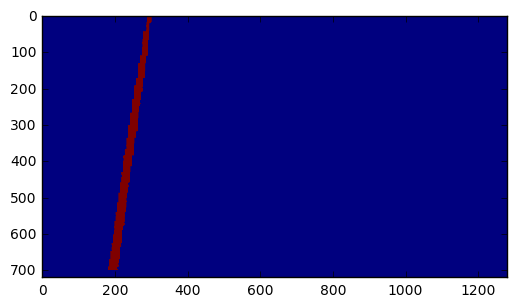

In [270]:
x_pixels,y_pixels = filter_pixels(top_down,x_center)
size = (720,1280)
new_image = np.zeros(size)

for x,y in zip (x_pixels, y_pixels):
    new_image[y][x] = 1

plt.imshow(new_image)
    
    



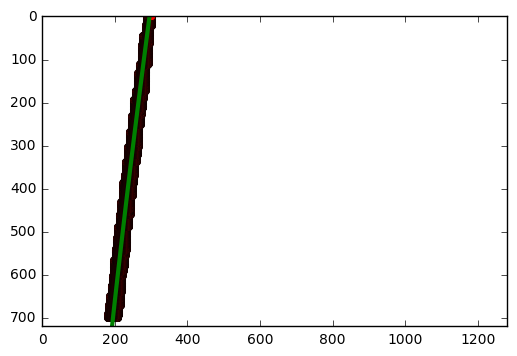

In [274]:
yvals = np.linspace(0, 100, num=101)*7.2

left_fit = np.polyfit(y_pixels, x_pixels, 2)
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]

plt.plot(x_pixels, y_pixels, 'o', color='red')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, yvals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [220]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [ ]:
right_lane = Line()
lefth_lane = Line()